# TestGrid EDA 


In this notebook we will explore how to access the existing testgrid data at testgrid.k8s.io, giving specific attention to [Red Hat's CI dashboards](https://testgrid.k8s.io/redhat-openshift-informing).

To start, we will rely on some of the work already established by the sippy team [here](https://github.com/openshift/sippy/blob/46ad8d209ed1f4b8d5e5e6fa8033088a593d695c/main.go#L49-L249) to access the data aggregated in testgrid and convert it into a format that can directly analyzed in a notebook.  

**What is testgrid?** According to the project's [readme](https://github.com/GoogleCloudPlatform/testgrid) it is a, "highly configurable, interactive dashboard for viewing your test results in a grid!" In other words, its an aggregation and visualization platform for CI data. Hopefully, this aggregation encodes some of the subject matter experts' knowledge, and will provide better initial features than going straight to the more complex underlying CI data [here](https://gcsweb-ci.apps.ci.l2s4.p1.openshiftapps.com/gcs/origin-ci-test/logs/).     

Also, for this initial stage, we will be making the assumption that the grid format for visualizing CI data, with columns representing days and rows representing tests with the value of each being either passed, failed, or not run, as a meaningful representation for further analysis and possible machine learning application.    

In [21]:
import requests
import json
import re
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

from IPython.display import Image
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set()

%matplotlib inline

### List all the available dashboards

We need a programmatic way to access all the available Red Hat Dashboards on testgrid. This can be done by scraping the html for any one of the dashboards. 

In [2]:
response = requests.get("https://testgrid.k8s.io/redhat-openshift-informing?id=dashboard-group-bar")

In [3]:
html = BeautifulSoup(response.content)
testgrid_script = html.findAll("script")[2]
testgrid_script = testgrid_script.text.split()[5].split(",")
dashboard_names = [x.split(":")[1] for x in testgrid_script if "name" in x]
dashboard_names

['"redhat-openshift-informing"',
 '"redhat-openshift-ocp-release-3.11-informing"',
 '"redhat-openshift-ocp-release-4.1-blocking"',
 '"redhat-openshift-ocp-release-4.1-informing"',
 '"redhat-openshift-ocp-release-4.2-blocking"',
 '"redhat-openshift-ocp-release-4.2-informing"',
 '"redhat-openshift-ocp-release-4.3-blocking"',
 '"redhat-openshift-ocp-release-4.3-broken"',
 '"redhat-openshift-ocp-release-4.3-informing"',
 '"redhat-openshift-ocp-release-4.4-blocking"',
 '"redhat-openshift-ocp-release-4.4-broken"',
 '"redhat-openshift-ocp-release-4.4-informing"',
 '"redhat-openshift-ocp-release-4.5-blocking"',
 '"redhat-openshift-ocp-release-4.5-broken"',
 '"redhat-openshift-ocp-release-4.5-informing"',
 '"redhat-openshift-ocp-release-4.6-blocking"',
 '"redhat-openshift-ocp-release-4.6-broken"',
 '"redhat-openshift-ocp-release-4.6-informing"',
 '"redhat-openshift-ocp-release-4.7-blocking"',
 '"redhat-openshift-ocp-release-4.7-broken"',
 '"redhat-openshift-ocp-release-4.7-informing"',
 '"redha

### Inspect at a specific release summary dashboard

Now that we have a programmatic way of collecting all the dashboard names we can use this later on to collect all the available data provided by testgrid. Let's take a look at a specific dashboard and see what kind of info its summary holds. 

In [4]:
dashboard = "redhat-openshift-ocp-release-4.2-informing"

In [5]:
response = requests.get(f"https://testgrid.k8s.io/{dashboard}/summary")

In [6]:
data = response.json()

In [7]:
ocp42 = pd.DataFrame(data)
ocp42

,promote-release-openshift-machine-os-content-e2e-aws-4.1,promote-release-openshift-machine-os-content-e2e-aws-4.2,promote-release-openshift-machine-os-content-e2e-aws-4.2-s390x,release-openshift-ocp-e2e-aws-scaleup-rhel7-4.2,release-openshift-ocp-installer-console-aws-4.2,release-openshift-ocp-installer-e2e-aws-fips-4.2,release-openshift-ocp-installer-e2e-aws-fips-serial-4.2,release-openshift-ocp-installer-e2e-aws-mirrors-4.2,release-openshift-ocp-installer-e2e-aws-proxy-4.2,release-openshift-ocp-installer-e2e-aws-upi-4.2,...,release-openshift-origin-installer-e2e-aws-sdn-multitenant-4.2,release-openshift-origin-installer-e2e-aws-upgrade-4.1-stable-to-4.2-ci,release-openshift-origin-installer-e2e-aws-upgrade-4.2-stable-to-4.2-nightly,release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1-to-4.2,release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.2,release-openshift-origin-installer-e2e-azure-upgrade-4.2,release-openshift-origin-installer-e2e-gcp-4.2,release-openshift-origin-installer-e2e-gcp-serial-4.2,release-openshift-origin-installer-e2e-gcp-upgrade-4.2,release-openshift-origin-installer-old-rhcos-e2e-aws-4.2
alert,,,,,,no completed results,no completed results,,,,...,,,,,,,,,,
last_run_timestamp,1600284278000,1600278480000,1600258532000,1600256179000,1600277222000,0,0,1600265303000,1600269224000,1600277225000,...,1600268757000,1600284269000,1600283128000,1600246985000,1600250816000,1600265303000,1600265301000,1600273978000,1600265273000,1600257654000
last_update_timestamp,1600284369,1600284373,1600284365,1600284505,1600284504,1600284510,1600284513,1600284533,1600284542,1600284552,...,1600284651,1600284669,1600284650,1600284658,1600284661,1600284669,1600284683,1600284677,1600284683,1600284699
latest_green,,,,2e1b15841,1,no recent greens,no recent greens,1,1,1,...,1,1,1,no recent greens,1,1,1,1,1,1
overall_status,PASSING,PASSING,PASSING,FLAKY,PASSING,STALE,STALE,FLAKY,FLAKY,FLAKY,...,FLAKY,FLAKY,FLAKY,FAILING,FLAKY,FLAKY,FLAKY,FLAKY,FAILING,FLAKY
overall_status_icon,done,done,done,remove_circle_outline,done,error_outline,error_outline,remove_circle_outline,remove_circle_outline,remove_circle_outline,...,remove_circle_outline,remove_circle_outline,remove_circle_outline,warning,remove_circle_outline,remove_circle_outline,remove_circle_outline,remove_circle_outline,warning,remove_circle_outline
status,10 of 10 (100.0%) recent columns passed (10 of...,10 of 10 (100.0%) recent columns passed (10 of...,10 of 10 (100.0%) recent columns passed (10 of...,4 of 10 (40.0%) recent columns passed (6464 of...,10 of 10 (100.0%) recent columns passed (3790 ...,no completed results,no completed results,8 of 10 (80.0%) recent columns passed (9144 of...,7 of 10 (70.0%) recent columns passed (9086 of...,7 of 10 (70.0%) recent columns passed (8179 of...,...,4 of 10 (40.0%) recent columns passed (8233 of...,8 of 9 (88.9%) recent columns passed (188 of 1...,7 of 9 (77.8%) recent columns passed (149 of 1...,0 of 10 (0.0%) recent columns passed (93 of 11...,8 of 10 (80.0%) recent columns passed (181 of ...,9 of 10 (90.0%) recent columns passed (209 of ...,4 of 10 (40.0%) recent columns passed (7765 of...,7 of 10 (70.0%) recent columns passed (629 of ...,7 of 10 (70.0%) recent columns passed (160 of ...,2 of 10 (20.0%) recent columns passed (2168 of...
tests,[],[],[],[],[],[],[],[],[],[],...,[],[],[],"[{'display_name': 'Overall', 'test_name': 'Ove...",[],[],[],[],"[{'display_name': 'Overall', 'test_name': 'Ove...",[]
dashboard_name,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,...,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2

For each dashboard there are a number of jobs associated with it (We will use these column names later to get the access the detailed data). And for each job we have number of features, some which contain additional data. 

* last run
* last update
* latest_green
* overall_status
* overall_status_icon
* status**
* tests**
* dashboard_name
* healthiness**

_** features that have additional data_

Let's take a look the additional data stored in status and tests for the job, "release-openshift-ocp-installer-e2e-openstack-4.2"

In [8]:
ocp42.loc["status","release-openshift-ocp-installer-e2e-openstack-4.2"]

'0 of 9 (0.0%) recent columns passed (3592 of 3630 or 99.0% cells)'

Status is a string value constructed by some other underlying data not present in the summary. I believe this is stating, for the last 10 runs, none were completely successful (100% pass) which in this case is equivalent to 4500 individual test not passing out of a total of 4533.    

In [9]:
pd.DataFrame(ocp42.loc["tests", "release-openshift-ocp-installer-e2e-openstack-4.2"])

""


These tests are ones that have been selected as "alerts" to display on the summary page by testgrid for a specific job on the dashboard. Its unclear here what logic is used to raise tests to "alert" status but it's likely the number or percent of failures(?). We also get the number of failures, as well as the time of the first failure and the time of the last time the test passed.  

**Possible features**

If we were limited to the data provided by a summary we could use some of the following things as vector feature to encode a dashboard:

* percent PASSING
* percent FLAKY
* percent FAILING
* percent STALE
* percent of recent columns passed
* percent cells passed
* average number of alerts in "tests"
* average fail_count across all "tests" 
* average seconds between first fail and last pass

However, there is a lot of summarizing going on here and it does not take into account the _grids_ in the testgrid tool. Let's move on the more detailed data and see what we have access to there. 

## Detailed View

Lets dig into the time series data in the detailed test grids.

To pull the desired json we can follow this syntax: 

`https://testgrid.k8s.io/{dashboard_name}/table?&show-stale-tests=&tab={job_name}`

From the work above we know how to get the list of all the dashboards and associated jobs. Here we will get the data for the job "release-openshift-ocp-installer-e2e-vsphere-upi-serial-4.2" as an example.

In [10]:
response = requests.get("https://testgrid.k8s.io/redhat-openshift-ocp-release-4.2-informing/table?&show-stale-tests=&tab=release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1-to-4.2")

The first thing we want to do is see what what keys we have in our detailed job data. Below we can see that there are a number of fields in this json, but the one we are going to focus on for now is "tests" as it contains the information we need to recreate the testgrids as dataframes or arrays, along with some additional info.   

In [11]:
for i in response.json().keys():
    print(i)

test-group-name
query
status
phase-timer
cached
summary
bugs
changelists
column_ids
custom-columns
column-header-names
groups
metrics
tests
row_ids
timestamps
clusters
test_id_map
test-metadata
stale-test-threshold
num-stale-tests
add-tabular-names-option
show-tabular-names
description
bug-component
code-search-path
open-test-template
file-bug-template
attach-bug-template
results-url-template
code-search-url-template
about-dashboard-url
open-bug-template
context-menu-template
results-text
latest-green
triage-enabled
notifications
overall-status


Looking at the complete json output for tests, looks like there are a number of fields that currently aren't populated or have duplicate data, so lets go ahead and drop them. Specifically, "linked_bugs", "message", "short_texts", user_property", "target", and "original-name".   

In [12]:
details = pd.DataFrame(response.json()["tests"]).drop(["linked_bugs","messages","short_texts",
                                             "user_property","target","original-name"],axis=1)
details

,name,alert,statuses
0,Overall,"{'fail-cl': '1', 'fail-count': 100, 'fail-time...","[{'count': 100, 'value': 12}]"
1,operator.Run template e2e-aws-upgrade - e2e-aw...,None,"[{'count': 1, 'value': 12}, {'count': 2, 'valu..."
2,Monitor cluster while tests execute,"{'fail-cl': '1', 'fail-count': 65, 'fail-time'...","[{'count': 1, 'value': 0}, {'count': 2, 'value..."
3,[Disruptive] Cluster upgrade should maintain a...,"{'fail-cl': '1', 'fail-count': 65, 'fail-time'...","[{'count': 1, 'value': 0}, {'count': 2, 'value..."
4,operator.Run template e2e-aws-upgrade - e2e-aw...,None,"[{'count': 1, 'value': 1}, {'count': 2, 'value..."
5,"operator.Import the release payload ""initial"" ...",None,"[{'count': 3, 'value': 1}, {'count': 1, 'value..."
6,"operator.Import the release payload ""latest"" f...",None,"[{'count': 3, 'value': 1}, {'count': 1, 'value..."
7,operator.Run cluster install and upgrade e2e-a...,None,"[{'count': 28, 'value': 0}, {'count': 1, 'valu..."
8,job.initialize,None,"[{'count': 53, 'value': 0}, {'count': 1, 'valu..."
9,Bug 1812261: iptables is segfaulting,None,"[{'count': 1, 'value': 0}, {'count': 2, 'value..."


From the column "statuses" above we can see that the time series data is [run length encoded](https://en.wikipedia.org/wiki/Run-length_encoding). Let's add a decoded column so we can get the data in an array format we could use for machine learning. 

In [13]:
def decode_run_length(x):
    lst = []
    for run_length in x:
        extension = [run_length["value"]]*run_length["count"]
        lst.extend(extension)
    return lst

In [14]:
details["values"] = details["statuses"].apply(decode_run_length)

In [15]:
details

,name,alert,statuses,values
0,Overall,"{'fail-cl': '1', 'fail-count': 100, 'fail-time...","[{'count': 100, 'value': 12}]","[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1..."
1,operator.Run template e2e-aws-upgrade - e2e-aw...,None,"[{'count': 1, 'value': 12}, {'count': 2, 'valu...","[12, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 12, 1, 1, 1..."
2,Monitor cluster while tests execute,"{'fail-cl': '1', 'fail-count': 65, 'fail-time'...","[{'count': 1, 'value': 0}, {'count': 2, 'value...","[0, 12, 12, 0, 12, 12, 12, 12, 12, 12, 0, 0, 1..."
3,[Disruptive] Cluster upgrade should maintain a...,"{'fail-cl': '1', 'fail-count': 65, 'fail-time'...","[{'count': 1, 'value': 0}, {'count': 2, 'value...","[0, 12, 12, 0, 12, 12, 12, 12, 12, 12, 0, 0, 1..."
4,operator.Run template e2e-aws-upgrade - e2e-aw...,None,"[{'count': 1, 'value': 1}, {'count': 2, 'value...","[1, 12, 12, 0, 12, 12, 12, 12, 12, 12, 0, 1, 1..."
5,"operator.Import the release payload ""initial"" ...",None,"[{'count': 3, 'value': 1}, {'count': 1, 'value...","[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 12, 1, 1, 1, 1,..."
6,"operator.Import the release payload ""latest"" f...",None,"[{'count': 3, 'value': 1}, {'count': 1, 'value...","[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 12, 1, 1, 1, 1,..."
7,operator.Run cluster install and upgrade e2e-a...,None,"[{'count': 28, 'value': 0}, {'count': 1, 'valu...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,job.initialize,None,"[{'count': 53, 'value': 0}, {'count': 1, 'valu...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,Bug 1812261: iptables is segfaulting,None,"[{'count': 1, 'value': 0}, {'count': 2, 'value...","[0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, ..."


Now that we have all our data unrolled, lets plot it and confirm it matches the testgrid images displayed on website. 

_note: these did match at 11:30 09/16/2020 if they no longer appear to image needs update_

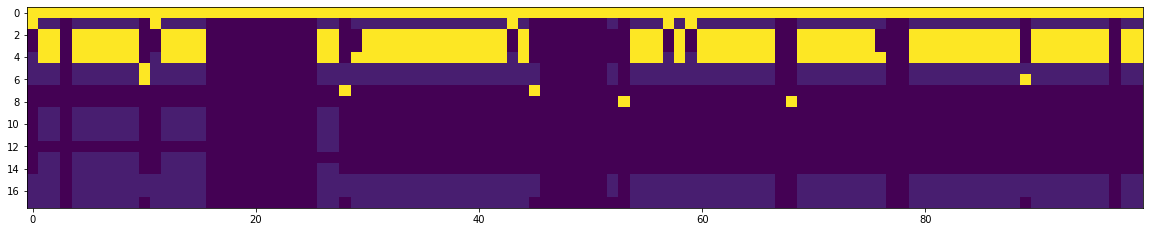

In [16]:
plt.figure(figsize=(20,10))
plt.imshow(np.array(list(details["values"].values)))
plt.show()

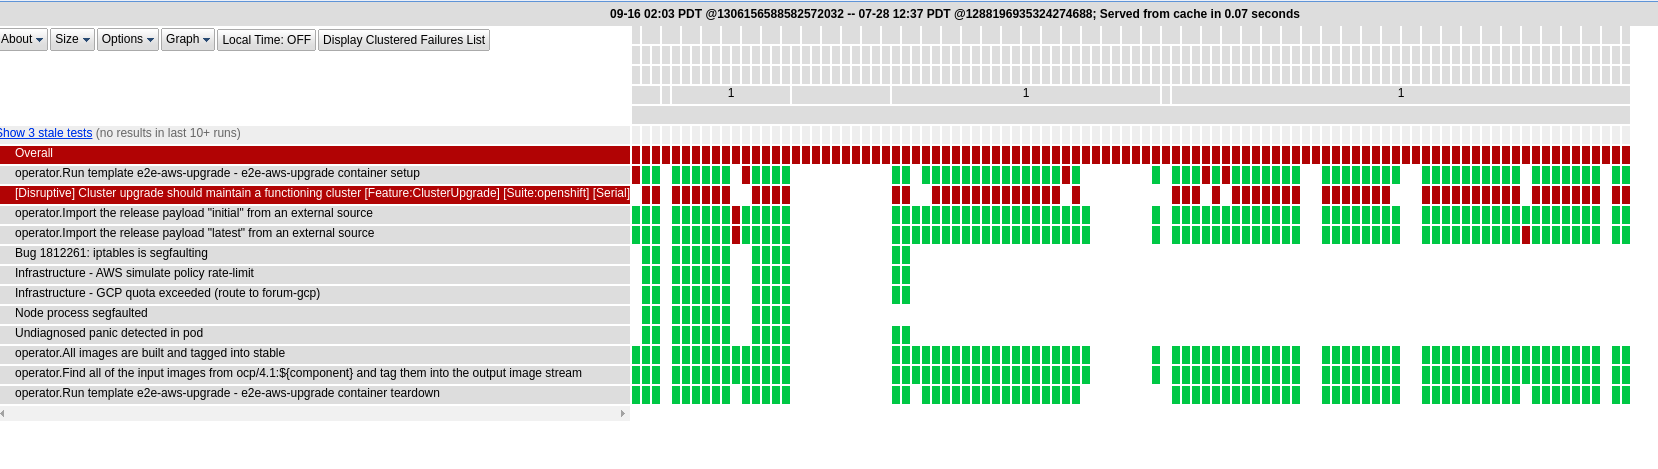

In [17]:
Image(filename='../docs/assets/images/testgrid_0.png')

Excellent. As we can see from the images above, we now have a means of going from any testgrid dashboard of interest directly to a 2d numpy representation of our grids where we could apply some 2D signal processing, computer vision or even convolutional neural network methods (maybe). Maybe even consider collecting a number of these objects over multiple days and treat it as a 3D tensor of 2D frames? These are just some possible ideas, but the main point here is that we now have the data represented in testgrid in a more data science friendly format, opening many more possible avenues for analysis.      

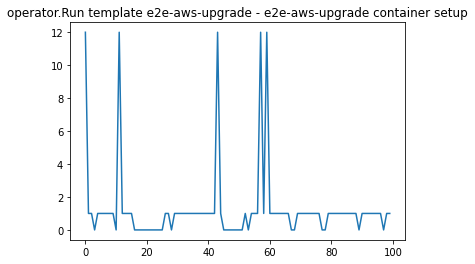

In [18]:
plt.plot(details["values"][1])
plt.title(details["name"][1])
plt.show()

We can also break our data down to a single time series, if we want to directly analyze the behavior of a single test with in this job. 

## Next steps

Now that we have a fairly clear view of the data available to us via testgrid and how to get it into a data science friendly format. The next thing we want to do is collect a large sample of this data and see how we can organize it in aggregate (across jobs). As this data appears to update at least daily, we also want to pull a large sample, so that we have a fixed data set to work with moving forward (one that is immutable (doesn't change on us every day), and available independent of the testgrid service's availability).   

What question are we left with? 
    * How comparable are the tests across different jobs  
    * Is job the level of analysis we care about? like is this the thing we want to encode and compare? Or is it tests, or dashboards? 
    

# Download Data

We will go ahead and download the grid data represented above in the data frame "details" for each job: 

In [33]:
download = False   
if download == True:    
    data = {}

    for dashboard in dashboard_names:
        response_1 = requests.get(f"https://testgrid.k8s.io/{dashboard}/summary")
        jobs = response_1.json().keys()
        dashboard_jobs = {}

        for job in jobs:
            response_2  = requests.get(f"https://testgrid.k8s.io/{dashboard}/table?&show-stale-tests=&tab={job}")
            if response_2.status_code != 200:
                continue

            grid = [{"name":x["name"] ,"statuses": x["statuses"]} for x in response_2.json()["tests"]]

            dashboard_jobs[job] = grid


        data[dashboard] = dashboard_jobs
        print(f"{dashboard} downloaded ")
else:
    print("Not Downloading")


"redhat-openshift-informing" downloaded 
"redhat-openshift-ocp-release-3.11-informing" downloaded 
"redhat-openshift-ocp-release-4.1-blocking" downloaded 
"redhat-openshift-ocp-release-4.1-informing" downloaded 
"redhat-openshift-ocp-release-4.2-blocking" downloaded 
"redhat-openshift-ocp-release-4.2-informing" downloaded 
"redhat-openshift-ocp-release-4.3-blocking" downloaded 
"redhat-openshift-ocp-release-4.3-broken" downloaded 
"redhat-openshift-ocp-release-4.3-informing" downloaded 
"redhat-openshift-ocp-release-4.4-blocking" downloaded 
"redhat-openshift-ocp-release-4.4-broken" downloaded 
"redhat-openshift-ocp-release-4.4-informing" downloaded 
"redhat-openshift-ocp-release-4.5-blocking" downloaded 
"redhat-openshift-ocp-release-4.5-broken" downloaded 
"redhat-openshift-ocp-release-4.5-informing" downloaded 
"redhat-openshift-ocp-release-4.6-blocking" downloaded 
"redhat-openshift-ocp-release-4.6-broken" downloaded 
"redhat-openshift-ocp-release-4.6-informing" downloaded 
"redhat

In [34]:
with open("../data/raw/testgrid.json", "w") as outfile:
    json.dump(data, outfile)

In [35]:
sys.getsizeof(data)

1192

It appears that all the existing test grids taken together only take up about 130 Mb, so we should be able to work with the whole set at once without too much trouble.  

Now that we have our whole data set together, lets go ahead and compare two jobs

In [65]:
one = pd.DataFrame(data['"redhat-openshift-ocp-release-4.2-informing"']["release-openshift-ocp-installer-console-aws-4.2"])
two = pd.DataFrame(data['"redhat-openshift-ocp-release-4.2-informing"']["release-openshift-ocp-installer-e2e-azure-4.2"])
one               

,name,statues
0,Overall,"[{'count': 12, 'value': 1}, {'count': 1, 'valu..."
1,"operator.Import the release payload ""latest"" f...","[{'count': 13, 'value': 1}, {'count': 2, 'valu..."
2,operator.Run template e2e-aws-console - e2e-aw...,"[{'count': 13, 'value': 1}, {'count': 2, 'valu..."
3,operator.Run template e2e-aws-console,"[{'count': 38, 'value': 0}, {'count': 2, 'valu..."
4,operator.Run template e2e-aws-console - e2e-aw...,"[{'count': 13, 'value': 1}, {'count': 2, 'valu..."
...,...,...
477,operator install service-catalog-apiserver,"[{'count': 13, 'value': 1}, {'count': 3, 'valu..."
478,operator install service-catalog-controller-ma...,"[{'count': 13, 'value': 1}, {'count': 3, 'valu..."
479,operator install storage,"[{'count': 13, 'value': 1}, {'count': 3, 'valu..."
480,operator.All images are built and tagged into ...,"[{'count': 31, 'value': 1}, {'count': 1, 'valu..."


In [66]:
one["statues"] = one["statues"].apply(decode_run_length)
two["statues"] = two["statues"].apply(decode_run_length)

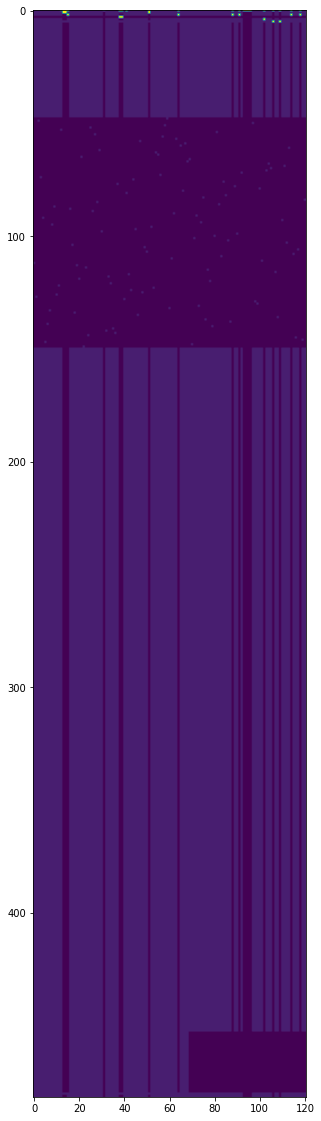

In [70]:
plt.figure(figsize=(20,20))
plt.imshow(np.array(list(one["statues"].values)))
plt.show()


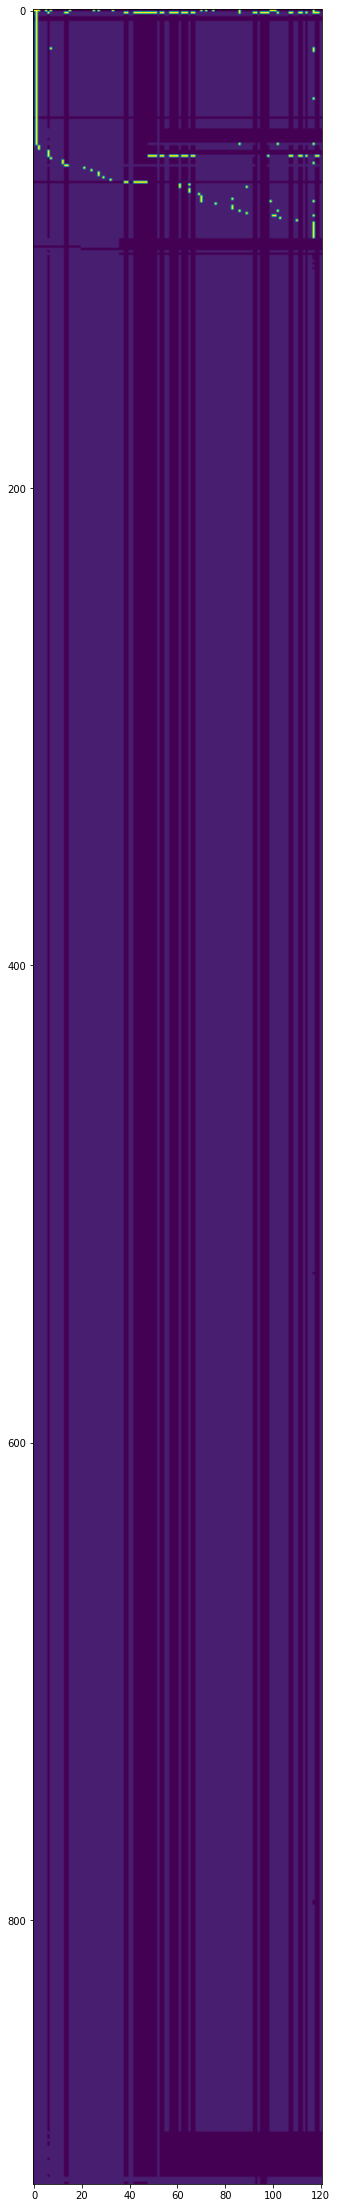

In [74]:
plt.figure(figsize=(20,40))
plt.imshow(np.array(list(two["statues"].values)))
plt.show()
